In [1]:
import sys
# sys.path.insert(0, '/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP')
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils
importlib.reload(utils)
TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
# Set the default dtype to float64
torch.set_default_dtype(TORCH_DTYPE)



# with open('data/processed_data.pkl', 'wb') as f:
#     pickle.save(f)

# To compare with samuale use:
# save_pickle('pietro_data', **{'K_pietro':K, 'K_tilde_pietro':K_tilde})    

Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)


## Parameters of the training

In [2]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

cellid      = 8   # Choose cell
ntilde      = 250  # Number of xtilde
kernfun     = utils.acosker # Choose kernel function

Nmstep  = 6   # Total number of M-steps iterations. 
Nestep  = 8   # Total number of E-steps iterations.
Maxiter = 10  # Iterations of the optimization algorithm comprising M and E steps

## Import the dataset and preprocess


In [3]:
# Import the data

# Set the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')

# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training data
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Concatenate Xtrain and Xval if not using validation set 
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)
# X = X_train
# R = R_train

# Choose a cell
r = R[:,cellid] # shape (nt,) where nt is the number of trials

# Reshape images to 1D vector
n_px_side = X.shape[1] # 108   
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
# If X_val is being used, reshape it
# X_val = torch.reshape(X_val, ( X_val.shape[0], X_val.shape[1]*X_val.shape[2])) # shape (n x val, 11664)=(nt, nx)

if rand_xtilde == True:
    torch.manual_seed(0)
    indices = torch.randint(0, X.shape[0], (ntilde,))
else:
    indices = torch.arange(0,ntilde, dtype=torch.int64)

xtilde = X[indices,:]


Device is: cuda:0


## Choose starting values of parameters

In [4]:
# In this code the learnt hyperparameters are the one in the dictionary 'theta'
# One can set them direcly or let generate_theta() set them based on the training set STAs
# To override the choice of generate_theta() just give theta as input 

# If one wants to compare the hyperparemeters set in Matthews's / Samuels's code one has to set
# logbetasam : and transform it to logbetaexpr with the function fromlogbetasam_to_logbetaexpr
# logrhosam  : and transform it to logrhoexpr with the function fromlogrhosam_to_logrhoexpr
# logsigma_0 : and transform it to sigma_0 exponetiating it

logsigma_0 = torch.tensor(0) # Samuele's code set the log of sigma
logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

# Alternatively one can directly set the hyperparameters to the values in the dictionary 'theta' below
# logbetaexpr = torch.tensor(4.65)
# logrhoexpr = torch.tensor(4.3)
sigma_0 = torch.exp(logsigma_0)

# Amp is not present in Matthews original code
Amp = torch.tensor(1.0) # Samuele's code set Amp to 1 does not learn it (absent in the code)

# Hypermarameters
theta = {'sigma_0': sigma_0, 'eps_0x':torch.tensor(0.), 'eps_0y':torch.tensor(0.), '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr, 'Amp': Amp }
# Set the gradient of the hyperparemters to be updateable 
for key, value in theta.items():
    # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0)
    # if key == 'Amp':
        # continue
    theta[key] = value.requires_grad_()

# Generate the hyperparameters tuple
# If hyperparameters are set manuelly:
hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

# A        = torch.tensor(0.007)
A        = torch.tensor(0.007)
logA     = torch.log(A)
f_params = {'logA': logA, 'lambda0':torch.tensor(0.31)}
# f_params = {'A': torch.tensor(0.0017), 'lambda0':torch.tensor(0.3697)}
# f_params = {'A': torch.tensor(-0.0807), 'lambda0': torch.tensor(0.3762)}
for key, value in f_params.items():
    f_params[key] = value.requires_grad_()

args = {
        'ntilde':  ntilde,
        'Maxiter': Maxiter,
        'Nmstep':  Nmstep,
        'Nestep':  Nestep,
        'kernfun': kernfun,
        'n_px_side': n_px_side,
        'display_prog':  False,
        'hyperparams_tuple': hyperparams_tuple,
        'f_params': f_params,
        'xtilde': xtilde,

        'm': torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
    }


updated sigma_0 to 1.0
updated eps_0x to 0.0
updated eps_0y to 0.0
updated -2log2beta to 4.806852819440055
updated -log2rho2 to 4.306852819440055
updated Amp to 1.0
 Before overloading
 Hyperparameters have been SET as  : beta = 0.05856070, rho = 0.02928035
 Samuele hyperparameters           : logbetasam = 4.9822, logrhosam = 7.0617

 After overloading
 Dict of learnable hyperparameters : sigma_0 = 1.00000000, eps_0x = 0.00000000, eps_0y = 0.00000000, -2log2beta = 4.80685282, -log2rho2 = 4.30685282, Amp = 1.00000000
 Hyperparameters from the logexpr  : beta = 0.04520382, rho = 0.08208500
 Samuele hyperparameters           : logbetasam = 5.5000, logrhosam = 5.0000


## Fit the model
Also returns a tracking dictionary for important values

In [5]:
theta_fit, f_params_fit, m_b_fit, V_b_fit, C_fit, mask_fit, K_tilde_b_fit, K_tilde_inv_b_fit, B, values_track_fit = utils.varGP(X, r, **args)

# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
model_b = {
    'theta': theta_fit,
    'f_params': f_params_fit,
    'm_b': m_b_fit,
    'V_b': V_b_fit,
    'C'  : C_fit,
    'mask': mask_fit,
    'K_tilde_inv_b': K_tilde_inv_b_fit,
    'K_tilde_b': K_tilde_b_fit,
    'B': B,
    'cellid' : cellid,
    'ntilde' : ntilde,
    'Maxiter': Maxiter,
    'Nmstep' : Nmstep,
    'Nestep' : Nestep,
    'kernfun': kernfun,
    'values_track': values_track_fit,
}


# Save the model
# save_pickle('pietro_model', **model)

*Iteration*: 0
 2935.8156 = logmarginal in m-step
 2919.3216 = logmarginal in m-step
 2919.2054 = logmarginal in m-step
 2919.2054 = logmarginal in m-step
 2912.8331 = logmarginal in m-step
 2912.8234 = logmarginal in m-step
 2912.8234 = logmarginal in m-step
 2912.3263 = logmarginal in m-step
 2912.3183 = logmarginal in m-step
*Iteration*: 1
 2842.3308 = logmarginal in m-step
 2820.1483 = logmarginal in m-step
 2819.8250 = logmarginal in m-step
 2819.8250 = logmarginal in m-step
 2807.2734 = logmarginal in m-step
 2807.1597 = logmarginal in m-step
 2807.1597 = logmarginal in m-step
 2801.9681 = logmarginal in m-step
 2801.9453 = logmarginal in m-step
*Iteration*: 2
 2761.4158 = logmarginal in m-step
 2741.7209 = logmarginal in m-step
 2741.4208 = logmarginal in m-step
 2741.4208 = logmarginal in m-step
 2729.7343 = logmarginal in m-step
 2729.6239 = logmarginal in m-step
 2729.6239 = logmarginal in m-step
 2724.7793 = logmarginal in m-step
 2724.7690 = logmarginal in m-step
*Iteration

## Evaluate the model on the test set using the explained variance and plot it



 Pietro's model: R2 = 0.90 ± 0.02 Cell: 8 Maxiter = 10, Nestep = 8, nMstep = 6 



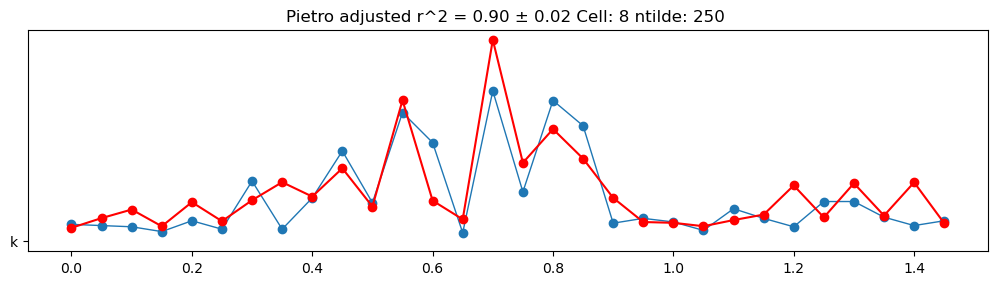

In [6]:
torch.set_grad_enabled(False)


# Predict and test
R_test_cell, R_pred_cell, r2, sigma_r2 = utils.test(X_test, R_test, xtilde, **model_b )


R_test_cell = R_test_cell.cpu().numpy()
R_pred_cell = R_pred_cell.cpu().numpy()
r2          = r2.cpu().numpy()
sigma_r2    = sigma_r2.cpu().numpy()

# Plot results after putting on cpu, numpy.
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(5, 5,
            left=0.1, right=0.9, bottom=0.1, top=0.9,
            wspace=0.3, hspace=0.7)
dt = 0.05
time_values = dt * np.arange( len(R_pred_cell) )
ax = fig.add_subplot(gs[3:, :])
ax.plot(time_values, np.mean(R_test_cell, axis=0) / 0.05, 'o-',  'k', linewidth=1)

ax.plot(time_values, R_pred_cell / 0.05, 'o-', color='red', label='GP')
# ax.errorbar(time_values, R_predicted / 0.05, yerr=np.sqrt(sigma2_f[:,0].cpu()) / 0.05, color='red')
# ax.legend(['data', 'GP'], loc='upper right', fontsize=14)
txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Cell: {cellid} ntilde: {ntilde} '
ax.set_title(f'{txt}')
# ax.set_ylabel('Firing rate (Hz)')
plt.show()
plt.close()


a=1